# Effects of interferon stimulation on immune cells

Demonstrating differential expression and differential variance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
import time

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.decomposition import PCA

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

### Create AnnData object and attach the metadata for interferon dataset

This dataset was used for the demuxlet paper, https://www.nature.com/articles/nbt.4042

In [6]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'

In [7]:
metadata = pd.read_csv(data_path + 'GSE96583_batch2.total.tsne.df.tsv', sep='\t')

In [8]:
ctrl_adata = sc.read_10x_mtx(data_path + 'ctrl_mtx/')
stim_adata = sc.read_10x_mtx(data_path + 'stim_mtx/')

In [9]:
both_barcodes = list(set(ctrl_adata.obs.index) & set(stim_adata.obs.index))
stim_adata.obs.index = [bc + '1' if bc in both_barcodes else bc for bc in stim_adata.obs.index.tolist()]

In [10]:
combined_X = sp.sparse.vstack([ctrl_adata.X, stim_adata.X])
combined_bc = ctrl_adata.obs.index.tolist() + stim_adata.obs.index.tolist()

In [11]:
adata = sc.AnnData(combined_X)
adata.obs.index = combined_bc
adata.var = ctrl_adata.var
adata.obs = adata.obs.join(metadata, how='left')
adata.obs['ind'] = adata.obs['ind'].astype('category')
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obsm['X_tsne'] = adata.obs[['tsne1', 'tsne2']].values
adata.write(data_path + 'interferon.h5ad')

... storing 'stim' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


### Filter for singlets

In [12]:
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

In [13]:
adata.shape

(24673, 35635)

### Perform some basic filtering

In [14]:
sc.pp.filter_genes(adata, min_cells=50)

In [15]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[(adata.obs['n_counts'] > 10), :].copy()

In [16]:
sc.pp.filter_genes_dispersion(adata, min_mean=0.03, max_mean=100, min_disp=0.1)

In [17]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

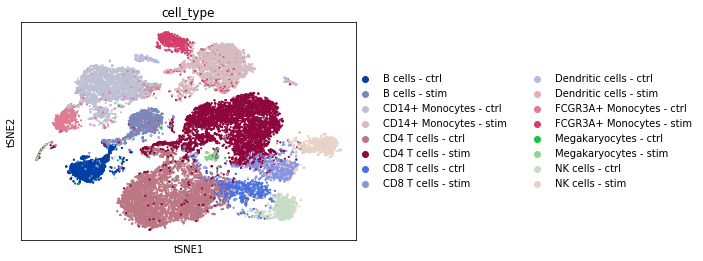

In [18]:
sc.pl.tsne(adata, color='cell_type')

In [19]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1654


### Total UMI count distribution for each cell type

In [191]:
total_umi_content = {}
for cell_type in adata.obs.cell_type.drop_duplicates().values:
    total_umi_content[cell_type] = adata.X[(adata.obs.cell_type == cell_type).values, :].sum(axis=1)

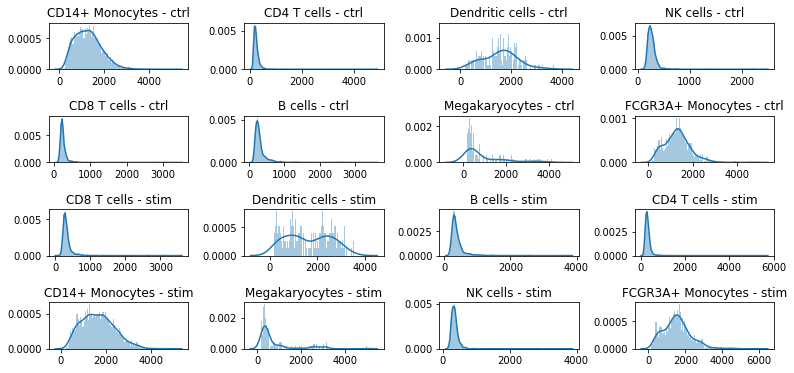

In [192]:
plt.figure(figsize=(13, 6))
plt.subplots_adjust(hspace=1, wspace=0.4)
idx = 1
for cell_type, total_umi_dist in total_umi_content.items():
    
    plt.subplot(4, 4, idx)
    sns.distplot(total_umi_dist, bins=100)
    plt.title(cell_type)
    idx +=1
# plt.subplot(4, 4, idx)
# sns.distplot(adata.X.sum(axis=1), bins=100);
# plt.title('All cells')

### Cell type marker genes

In [22]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [275]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(adata_ctrl, p=0.1, group_label='cell_type')

In [276]:
cell_type_stats = {}
for ct in adata_ctrl.obs.cell_type.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.compute_observed_statistics(group=ct)
    estimator.compute_observed_statistics(group=('-' + ct))
    
    estimator.compute_params(group=ct)
    estimator.compute_params(group=('-' + ct))

    estimator.compute_permuted_statistics(group=ct, num_permute=10)
    estimator.compute_permuted_statistics(group=('-' + ct), num_permute=10)
    
    t_stats, null_t_stats, pvals = estimator.differential_expression(ct, ('-' + ct), method='perm')
    cell_type_stats[ct] = {
        't_stat':t_stats,
        'null_t_stats':null_t_stats,
        'pvals': pvals
    }

Calculating stats for CD14+ Monocytes - ctrl
Calculating stats for CD4 T cells - ctrl
Calculating stats for Dendritic cells - ctrl
Calculating stats for NK cells - ctrl
Calculating stats for CD8 T cells - ctrl
Calculating stats for B cells - ctrl
Calculating stats for Megakaryocytes - ctrl
Calculating stats for FCGR3A+ Monocytes - ctrl


In [297]:
for ct in adata_ctrl.obs.cell_type.drop_duplicates():
    
    print(
        '{} markers:'.format(ct), 
        adata_ctrl.var.index[
            np.argsort(cell_type_stats[ct]['t_stat'])[::-1][np.where(np.isnan(cell_type_stats[ct]['t_stat']))[0].shape[0]:][:75]].tolist())
    _, fdr = fdrcorrection(cell_type_stats[ct]['pvals'])
    print('Number of sig. at 0.01 FDR:', (fdr < 0.01).sum())
    print()

CD14+ Monocytes - ctrl markers: ['S100A8', 'S100A9', 'CLEC5A', 'CLEC4E', 'TYROBP', 'FTL', 'MGST1', 'CCL2', 'PLA2G7', 'S100A12', 'CD63', 'IL8', 'IER3', 'HPSE', 'LGALS1', 'ANPEP', 'C15orf48', 'FCER1G', 'VCAN', 'CTB-61M7.2', 'FCN1', 'LHFPL2', 'TREM1', 'FNDC3B', 'CD14', 'CTSB', 'THBS1', 'TGFBI', 'LACC1', 'ANXA5', 'SLC7A11', 'CD300E', 'OLR1', 'C5AR1', 'CYP27A1', 'TYMP', 'S100A10', 'GRN', 'PDLIM7', 'ENG', 'PID1', 'DUSP6', 'S100A4', 'GPR84', 'SERPINB2', 'S100A6', 'CCR1', 'MAFB', 'S100A11', 'GPX1', 'ATP6V0B', 'RAC1', 'NCF2', 'PLAUR', 'LILRB4', 'SPI1', 'RAB13', 'SPHK1', 'CD68', 'CCL7', 'MARCKSL1', 'C19orf59', 'TIMP1', 'LGALS2', 'PVRL2', 'SIRPA', 'ANXA2', 'KYNU', 'FTH1', 'FPR3', 'PSAP', 'CXCL2', 'FCGRT', 'LGALS3', 'LIMS1']
Number of sig. at 0.01 FDR: 1151

CD4 T cells - ctrl markers: ['LEF1', 'TSHZ2', 'PASK', 'LTB', 'ADTRP', 'AQP3', 'CD3E', 'TRAT1', 'CD27', 'IL7R', 'NELL2', 'CD3G', 'CD3D', 'TNFRSF25', 'LCK', 'TMEM204', 'AES', 'SPOCK2', 'CD6', 'KLF2', 'PIK3IP1', 'ICOS', 'TMEM173', 'CCNG1', 'SFXN1

### Effect of interferon stimulation

In [298]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [299]:
estimator = simplesc.SingleCellEstimator(adata, p=0.1, group_label='cell_type')

In [300]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD4 T cells - stim')

In [301]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD4 T cells - stim')

In [302]:
estimator.compute_permuted_statistics(group='CD4 T cells - ctrl', num_permute=20)
estimator.compute_permuted_statistics(group='CD4 T cells - stim', num_permute=20)


In [303]:
t_stats, null_t_stats, pvals = estimator.differential_expression('CD4 T cells - ctrl', 'CD4 T cells - stim', method='perm')

In [304]:
_, fdr = fdrcorrection(pvals)

Text(0,0.5,'Count')

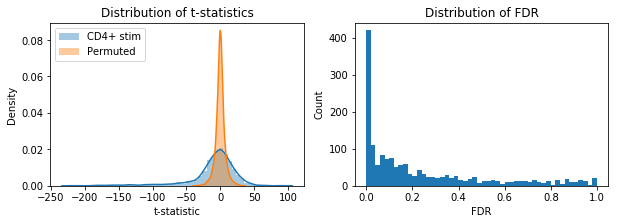

In [307]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(t_stats[~np.isnan(t_stats)]);
sns.distplot(null_t_stats[~np.isnan(null_t_stats)]);
plt.legend(['CD4+ stim', 'Permuted']);
plt.xlabel('t-statistic');
plt.ylabel('Density');
plt.title('Distribution of t-statistics')
plt.subplot(1, 2, 2);
plt.hist(fdr[~np.isnan(fdr)], bins=50);
plt.title('Distribution of FDR')
plt.xlabel('FDR');
plt.ylabel('Count')

In [308]:
print('Number of significant genes at 0.01 FDR:', (fdr < 0.01).sum())

Number of significant genes at 0.01 FDR: 356


In [309]:
print('Upregulated genes: ', adata.var.index[np.argsort(t_stats)[:50]].tolist())

Upregulated genes:  ['IFIT1', 'IFIT3', 'LY6E', 'IFIT2', 'LAMP3', 'CMPK2', 'RSAD2', 'ISG15', 'IFI44L', 'CCL8', 'CXCL10', 'MT2A', 'OAS3', 'IL1RN', 'ISG20', 'SAMD9L', 'CXCL11', 'TNFSF10', 'HERC5', 'IFI35', 'TGM1', 'GBP1', 'NEXN', 'TRIM22', 'TARBP1', 'RTP4', 'DDX58', 'IFITM3', 'ETV7', 'PARP9', 'OAS2', 'MX2', 'IFIH1', 'DDX60L', 'ZBP1', 'LGALS9', 'SPATS2L', 'SAMD9', 'APOBEC3B', 'FBXO6', 'OASL', 'HERC6', 'GBP5', 'DHX58', 'IFIT5', 'C5orf56', 'TREX1', 'LGALS3BP', 'PNPT1', 'LAP3']


In [310]:
print('Downregulated genes: ', adata.var.index[np.argsort(t_stats)[::-1][:50]].tolist())

Downregulated genes:  ['FPR3', 'CDC42EP2', 'ADAMDEC1', 'CLIC2', 'CYP27A1', 'EREG', 'CCL3L1', 'IL27', 'IRG1', 'MYOF', 'NUPR1', 'CLEC5A', 'VCAN', 'AMICA1', 'IL1B', 'IL8', 'C10orf54', 'PID1', 'S100A8', 'C19orf59', 'THBS1', 'CD27', 'GPX4', 'TGFBI', 'ABCG1', 'NELL2', 'CD82', 'CSTA', 'CXCL1', 'GABARAP', 'NCF1', 'LDLRAD4', 'ID3', 'AOAH', 'CD14', 'PLXDC2', 'LAIR1', 'ITGB2', 'TUBA4A', 'IL1R2', 'ITM2C', 'PLEKHF1', 'OLR1', 'FGFBP2', 'HLA-DMB', 'NSMCE1', 'ADAM8', 'CTB-61M7.2', 'LCK', 'AQP3']


### Compute the null distribution

In [555]:
adata_ctrl.obs['fake_cell_type'] = np.random.permutation(adata_ctrl.obs['cell_type'])

In [556]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(adata_ctrl, p=0.1, num_permute=3, group_label='fake_cell_type')

In [557]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD14+ Monocytes - ctrl')

In [558]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD14+ Monocytes - ctrl')

In [559]:
estimator.compute_permuted_statistics(group='CD4 T cells - ctrl')
estimator.compute_permuted_statistics(group='CD14+ Monocytes - ctrl')


In [560]:
t_statistic, null_t_statistic, pvals = estimator.differential_expression('CD4 T cells - ctrl', 'CD14+ Monocytes - ctrl', method='perm')

Text(0.5,1,'Distribution of p-values for shuffled labels')

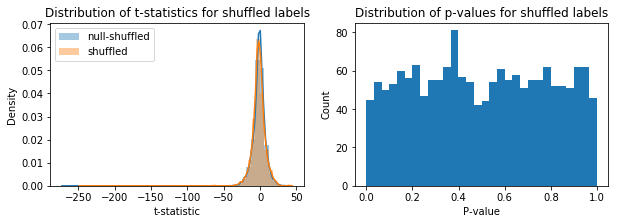

In [561]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
sns.distplot(null_t_stats[~np.isnan(null_t_stats)], bins=50);
sns.distplot(t_stats[~np.isnan(t_stats)], bins=50);
plt.title('Distribution of t-statistics for shuffled labels');
plt.ylabel('Density'); plt.xlabel('t-statistic');
plt.legend(['null-shuffled', 'shuffled']);
plt.subplot(1, 2, 2);
plt.hist(pvals, bins=30);
plt.ylabel('Count');plt.xlabel('P-value');
plt.title('Distribution of p-values for shuffled labels')